In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nir-generated-answers/generated_results_with_f1_llama2_chegeka.csv
/kaggle/input/nir-generated-answers/chegeka-shap1.xpynb
/kaggle/input/nir-generated-answers/rudetox-nir (1).ipynb
/kaggle/input/nir-generated-answers/chgk_generated_results_with_f1_mistral.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_vikhr_generated_results.csv
/kaggle/input/nir-generated-answers/Llama2_rutedox_generated_results.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_tinyllama_generated_results.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_mistral_generated_results.csv
/kaggle/input/nir-generated-answers/rudetox_Vikhr_generated_results.csv
/kaggle/input/nir-generated-answers/vikhr_chegeka_generated_results_with_f1.csv
/kaggle/input/nir-generated-answers/rudetox_Mistral_generated_results.csv
/kaggle/input/nir-generated-answers/Llama2_ruopenbookqa_generated_results.csv
/kaggle/input/nir-generated-answers/chegeka-2ndsemester-nir (2).ipynb
/kaggle/input/nir-generated-answers/lcs_vi

### Models

1. TinyLlama
2. Llama 2
3. Vikhr
4. Mistral

# Import data and libraries

In [1]:
%pip install sentence_transformers
%pip install shap
%pip install lime
%pip install seaborn
%pip install transformers


  Using cached shap-0.46.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.46.0-cp311-cp311-win_amd64.whl (456 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached lime-0.2.0.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import  chi2_contingency
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import warnings
import lime
from lime.lime_text import LimeTextExplainer
from transformers import AutoModelForCausalLM, AutoTokenizer

warnings.filterwarnings('ignore')

dfs = [
    r"..\..\data\CheGeka\generated_results_chegeka_mistral.csv",
    r"..\..\data\CheGeka\generated_results_with_f1_llama2_chegeka.csv",
    r"..\..\data\CheGeka\tinyllama_chegeka_generated_results_with_f1.csv",
    r"..\..\data\CheGeka\generated_results_vikhr.csv"
]

dataframes = []

for df in dfs:
    try:
        dataframes.append(pd.read_csv(df))
    except FileNotFoundError:
        print(f"File not found: {df}")
    except Exception as e:
        print(f"An error occurred while reading {df}: {e}")

In [32]:
df_tinyllama = pd.read_csv(r"..\..\data\CheGeka\generated_results_chegeka_mistral.csv",)
df_tinyllama.head()

,question,prompt,answer,generated_text
0,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,"1. ""Возвращение в будущее""\nОтвет: 2. ""Возвращ..."
1,Продолжение этого фильма Евгения Матвеева назы...,"Прочитайте вопрос из категории ""Любовь"" и отве...",любовь земная,1.\n\n## 1.\n\nThe film is about a young man w...
2,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,"1. ""Возвращение в будущее""\nОтвет: 2. ""Возвращ..."
3,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,1.\n\n## 1.\n\nThe film is a sequel to the 201...
4,Продолжение этого фильма Евгения Матвеева назы...,"Угадайте, в какой категории из ""Что? Где? Когд...",любовь земная,1990-е\n\nThe film is a sequel to the 1990 fil...


# Ground Truth

Посмотреть и дополнить информацию с эмбеддером для сравнения ответов между собой 

In [36]:
from sklearn.metrics import f1_score

#Exact Match
def calculate_exact_match(answer, generated_answer):
    return int(answer == generated_answer)

#F1 score
def calculate_f1_score(answer_tokens, generated_answer_tokens):
    common_tokens = set(answer_tokens) & set(generated_answer_tokens)
    
    if len(common_tokens) == 0:
        return 0.0
    
    precision = len(common_tokens) / len(generated_answer_tokens)
    recall = len(common_tokens) / len(answer_tokens)
    
    if precision + recall == 0:
        return 0.0
    
    return 2 * (precision * recall) / (precision + recall)


for df_path in dfs:
    df = pd.read_csv(df_path)
    
    df['calculated_f1_score'] = 0.0
    df['calculated_exact_match'] = 0
    
    # Calculate metrics for each row
    for idx, row in df.iterrows():
        answer = row['answer']
        generated_answer = row['generated_text']
        
        # Ensure answer and generated_answer are strings
        if pd.isna(answer) or pd.isna(generated_answer):
            continue  # Skip this row if either is NaN
        
        answer_tokens = answer.split()
        generated_answer_tokens = generated_answer.split()
        
        exact_match = calculate_exact_match(answer, generated_answer)
        df.at[idx, 'calculated_exact_match'] = exact_match
        
        f1 = calculate_f1_score(answer_tokens, generated_answer_tokens)
        df.at[idx, 'calculated_f1_score'] = f1
    
    # Save back to CSV with the same name
    df.to_csv(df_path, index=False)

    print(f"Results saved for dataset {df_path}:")
    print(df.head())

Results saved for dataset ..\..\data\CheGeka\generated_results_chegeka_mistral.csv:
                                            question  \
0  Продолжение этого фильма Евгения Матвеева назы...   
1  Продолжение этого фильма Евгения Матвеева назы...   
2  Продолжение этого фильма Евгения Матвеева назы...   
3  Продолжение этого фильма Евгения Матвеева назы...   
4  Продолжение этого фильма Евгения Матвеева назы...   

                                              prompt         answer  \
0  Вы участвуете в викторине "Что? Где? Когда?". ...  любовь земная   
1  Прочитайте вопрос из категории "Любовь" и отве...  любовь земная   
2  Вы участвуете в викторине "Что? Где? Когда?". ...  любовь земная   
3  Вы участвуете в викторине "Что? Где? Когда?". ...  любовь земная   
4  Угадайте, в какой категории из "Что? Где? Когд...  любовь земная   

                                      generated_text  calculated_f1_score  \
0  1. "Возвращение в будущее"\nОтвет: 2. "Возвращ...                  0.0  

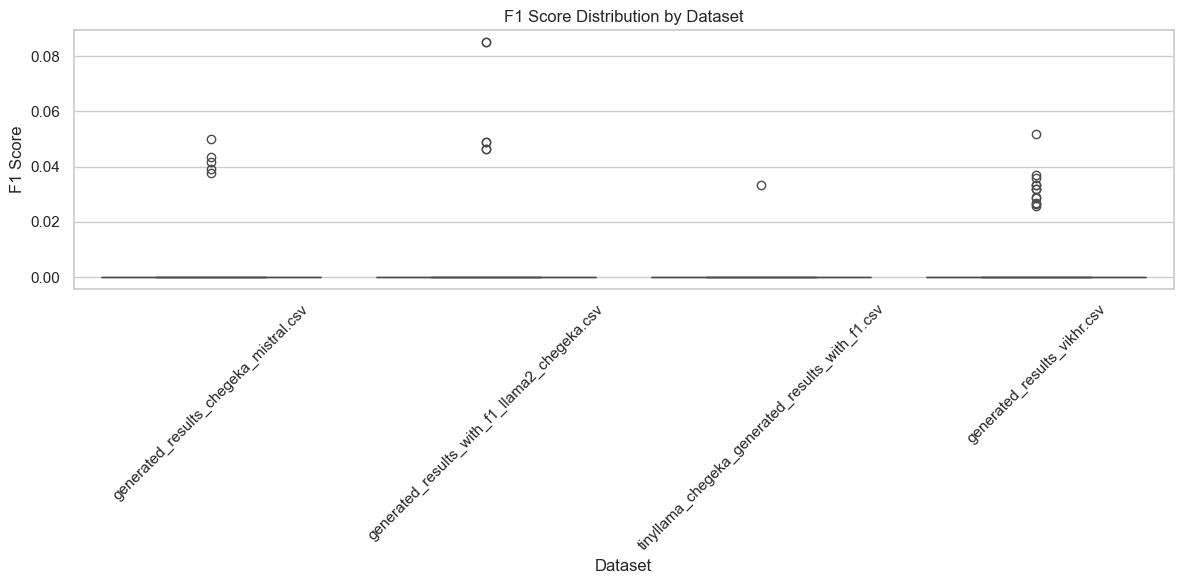

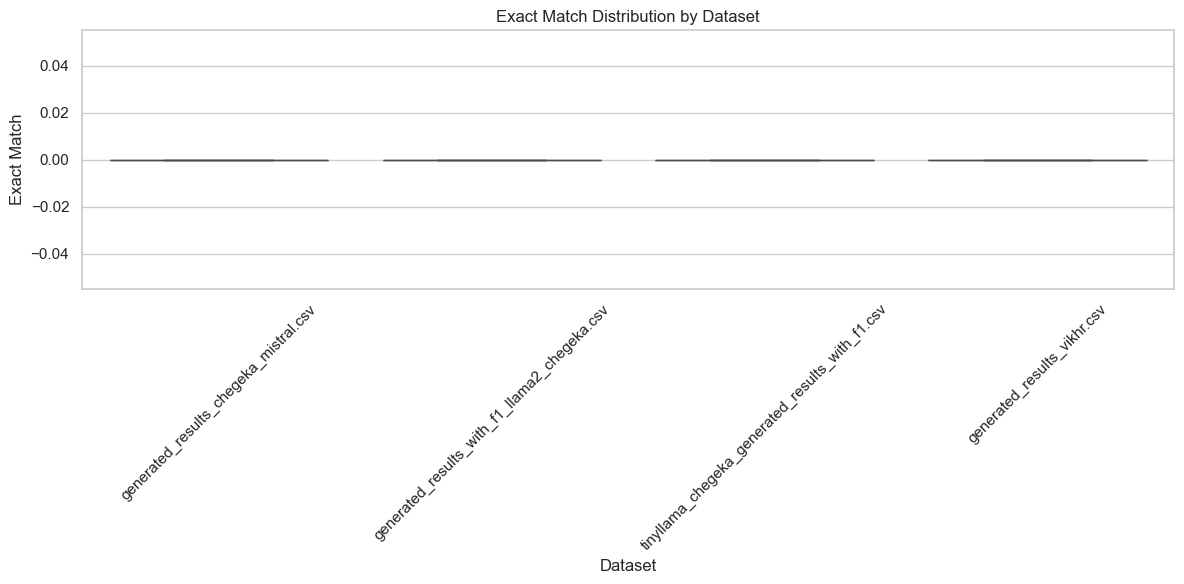

In [37]:
results = []
for df_path in dfs:
    df = pd.read_csv(df_path)
    # Include dataset name for later reference
    df['dataset'] = df_path.split("\\")[-1]  # Extracting just the file name
    results.append(df[['dataset', 'calculated_f1_score', 'calculated_exact_match']])

# Concatenate all DataFrames
combined_df = pd.concat(results, ignore_index=True)

# Plot F1 Score
plt.figure(figsize=(12, 6))
sns.boxplot(x='dataset', y='calculated_f1_score', data=combined_df)
plt.xticks(rotation=45)
plt.title('F1 Score Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

# Plot Exact Match
plt.figure(figsize=(12, 6))
sns.boxplot(x='dataset', y='calculated_exact_match', data=combined_df)
plt.xticks(rotation=45)
plt.title('Exact Match Distribution by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Exact Match')
plt.tight_layout()
plt.show()

# LIME, SHAP and Attention Matrix

<Figure size 1000x600 with 0 Axes>

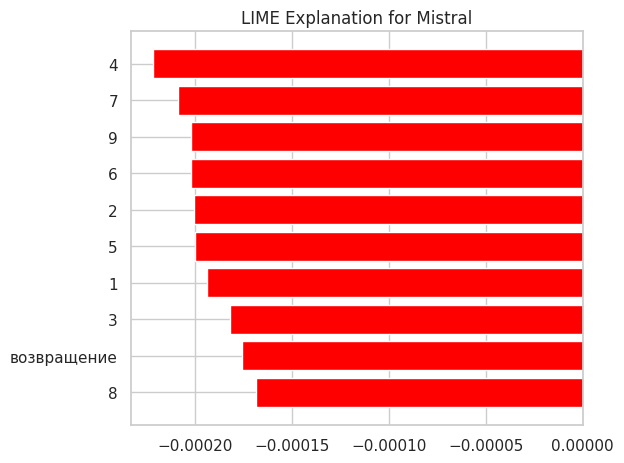


LIME Explanation for Mistral:
4: -0.00022202391811519966
7: -0.0002087684874415215
9: -0.00020206390309817875
6: -0.00020195984694789556
2: -0.00020082637859880536
5: -0.00020002757195019698
1: -0.00019396990370782212
3: -0.00018190285722944152
возвращение: -0.00017580875637931344
8: -0.0001684022391696412


<Figure size 1000x600 with 0 Axes>

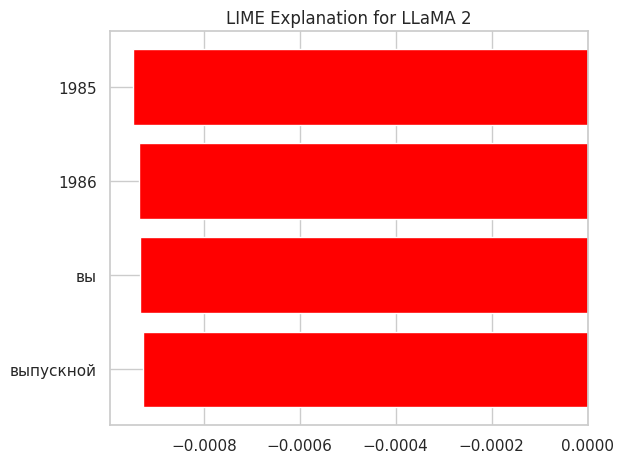


LIME Explanation for LLaMA 2:
1985: -0.0009480171297393011
1986: -0.0009353473654294507
вы: -0.000933615648508125
выпускной: -0.0009272371569934916


<Figure size 1000x600 with 0 Axes>

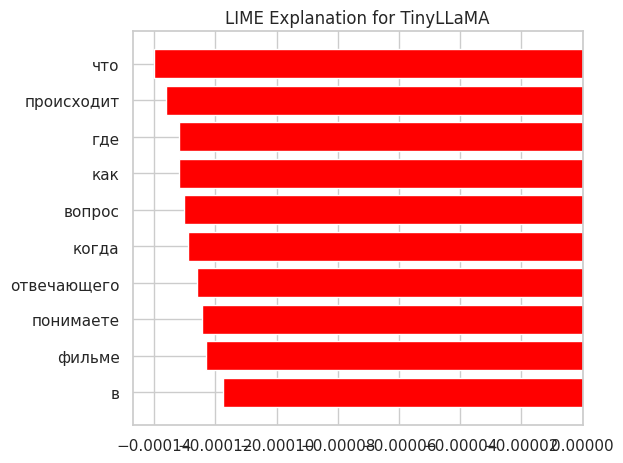


LIME Explanation for TinyLLaMA:
что: -0.00014003446908840558
происходит: -0.00013616598141993493
где: -0.000132019042461638
как: -0.00013174858104812522
вопрос: -0.00013020381723331036
когда: -0.0001289818844661758
отвечающего: -0.00012589199985238079
понимаете: -0.00012426717221401422
фильме: -0.00012292205563781068
в: -0.00011747064095091445


<Figure size 1000x600 with 0 Axes>

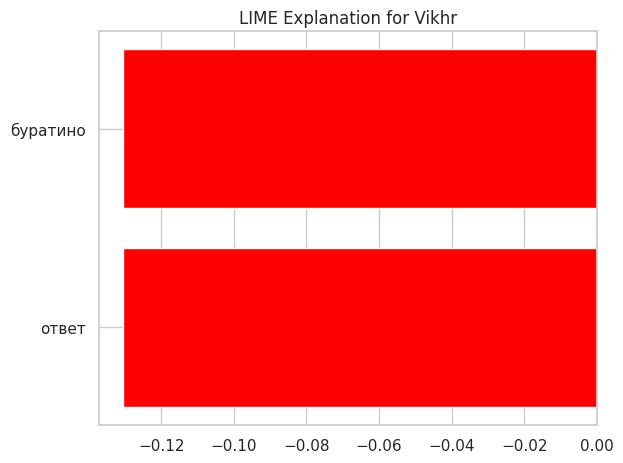


LIME Explanation for Vikhr:
буратино: -0.13060009310543527
ответ: -0.13058176034619692


In [46]:
def load_csv(file_path):
    return pd.read_csv(file_path)

model_names = ['Mistral', 'LLaMA 2', 'TinyLLaMA', 'Vikhr']

# Download and load models
def load_model(model_name):
    if model_name == 'Mistral':
        model_path = "mistralai/Mistral-7B-v0.1"
    elif model_name == 'LLaMA 2':
        model_path = "meta-llama/Llama-2-7b-hf"
    elif model_name == 'TinyLLaMA':
        model_path = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    elif model_name == 'Vikhr':
        model_path = "IlyaGusev/saiga_mistral_7b_lora"
    else:
        raise ValueError(f"Unknown model: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")
    return tokenizer, model


def explain_with_lime(text, classifier, model_name, num_features=10):
    explainer = LimeTextExplainer(class_names=['Incorrect', 'Correct'])
    exp = explainer.explain_instance(text, classifier.predict_proba, num_features=num_features)
    
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for {model_name}')
    plt.tight_layout()
    plt.savefig(f'lime_explanation_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nLIME Explanation for {model_name}:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight}")

# Example usage of LIME
for df, model_name in zip(dfs, model_names):
    classifier = CheGeKaClassifier(df)
    sample_text = df['generated_answer'].iloc[0]  # Get the first generated answer
    explain_with_lime(sample_text, classifier, model_name)

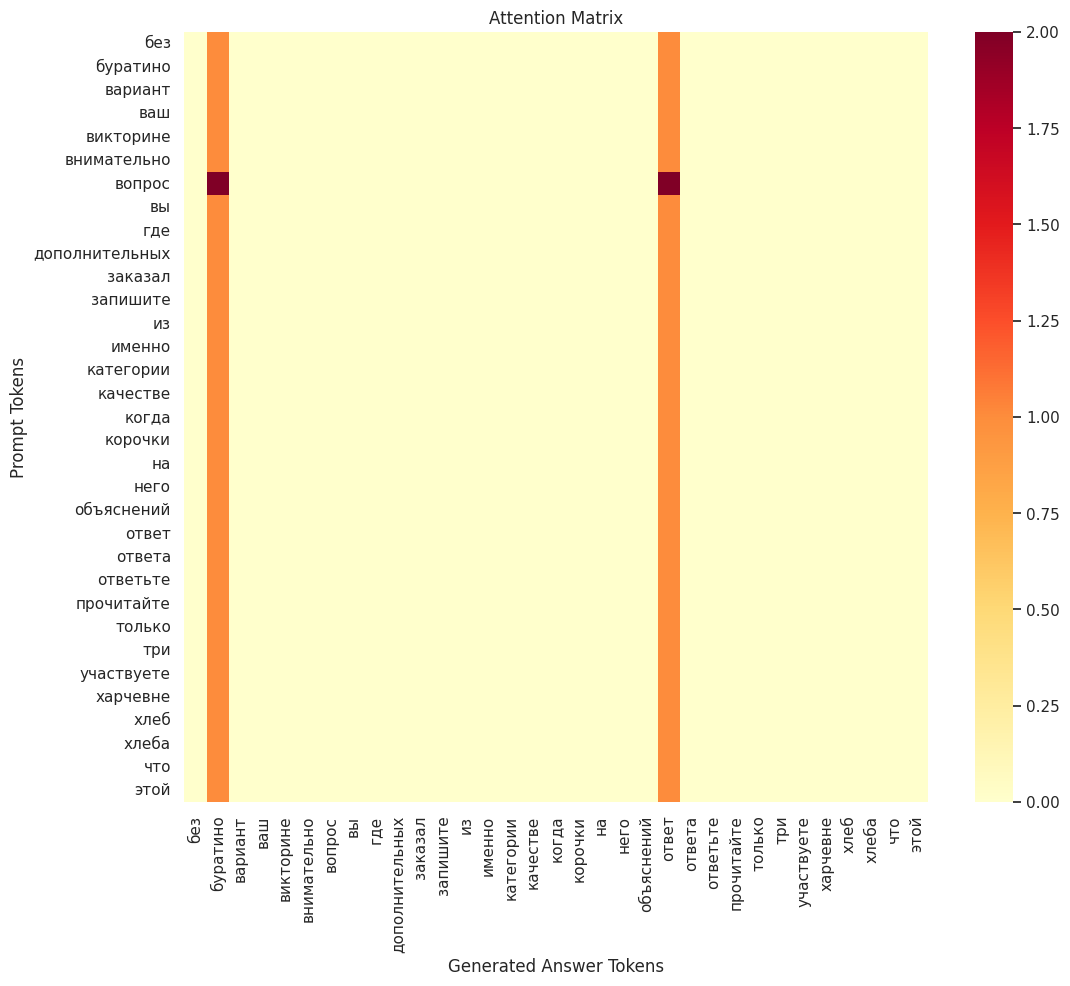

In [34]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def create_attention_matrix(prompt, generated_answer):
    vectorizer = CountVectorizer().fit([prompt, generated_answer])
    prompt_vector = vectorizer.transform([prompt]).toarray().flatten()
    answer_vector = vectorizer.transform([generated_answer]).toarray().flatten()
    
    attention_matrix = np.outer(prompt_vector, answer_vector)
    
    return attention_matrix, vectorizer.get_feature_names_out()

def visualize_attention_matrix(attention_matrix, tokens):
    plt.figure(figsize=(12, 10))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='YlOrRd')
    plt.title('Attention Matrix')
    plt.xlabel('Generated Answer Tokens')
    plt.ylabel('Prompt Tokens')
    plt.show()

# mistral
prompt = df['prompt'][0] 
generated_answer = df['generated_answer'][0]

attention_matrix, tokens = create_attention_matrix(prompt, generated_answer)
visualize_attention_matrix(attention_matrix, tokens)


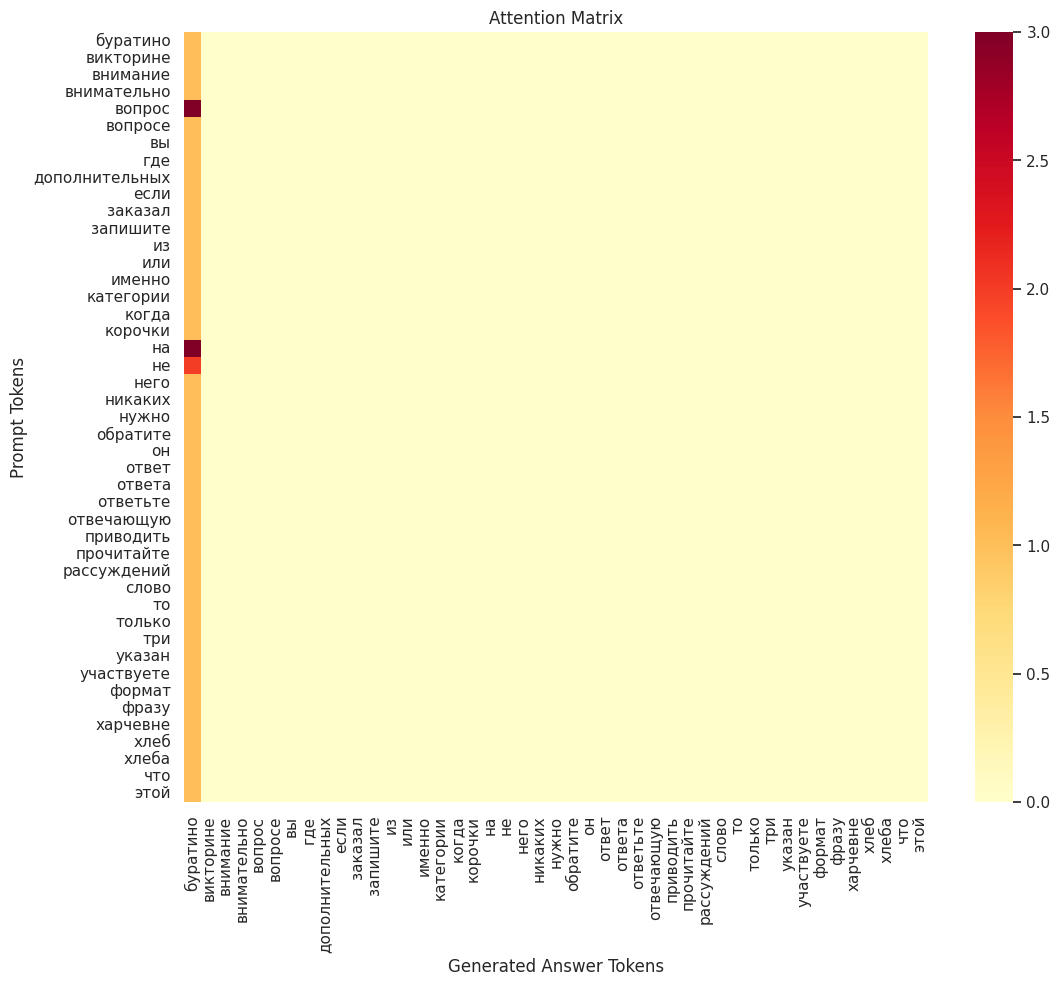

In [35]:
# LLama2
prompt = df['prompt'][1] 
generated_answer = df['generated_answer'][1]

attention_matrix, tokens = create_attention_matrix(prompt, generated_answer)
visualize_attention_matrix(attention_matrix, tokens)

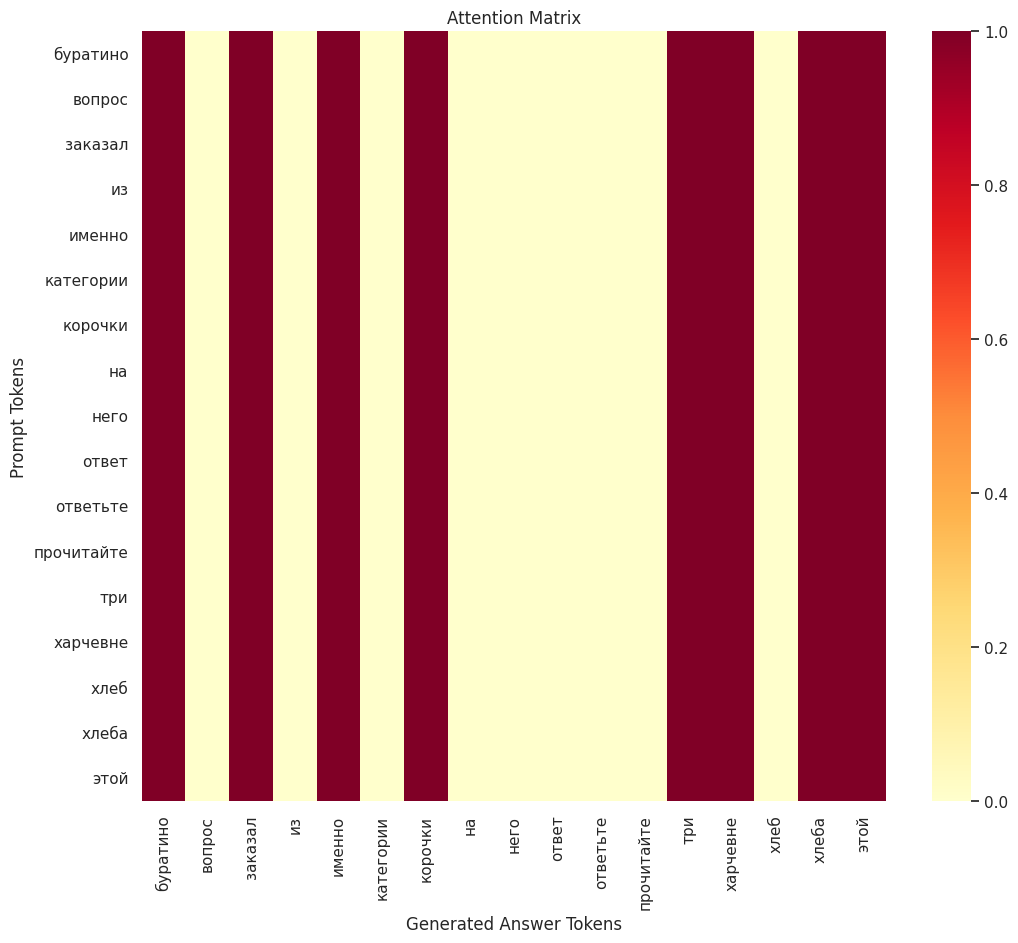

In [36]:
# Vikhr
prompt = df['prompt'][2] 
generated_answer = df['generated_answer'][2]

attention_matrix, tokens = create_attention_matrix(prompt, generated_answer)
visualize_attention_matrix(attention_matrix, tokens)

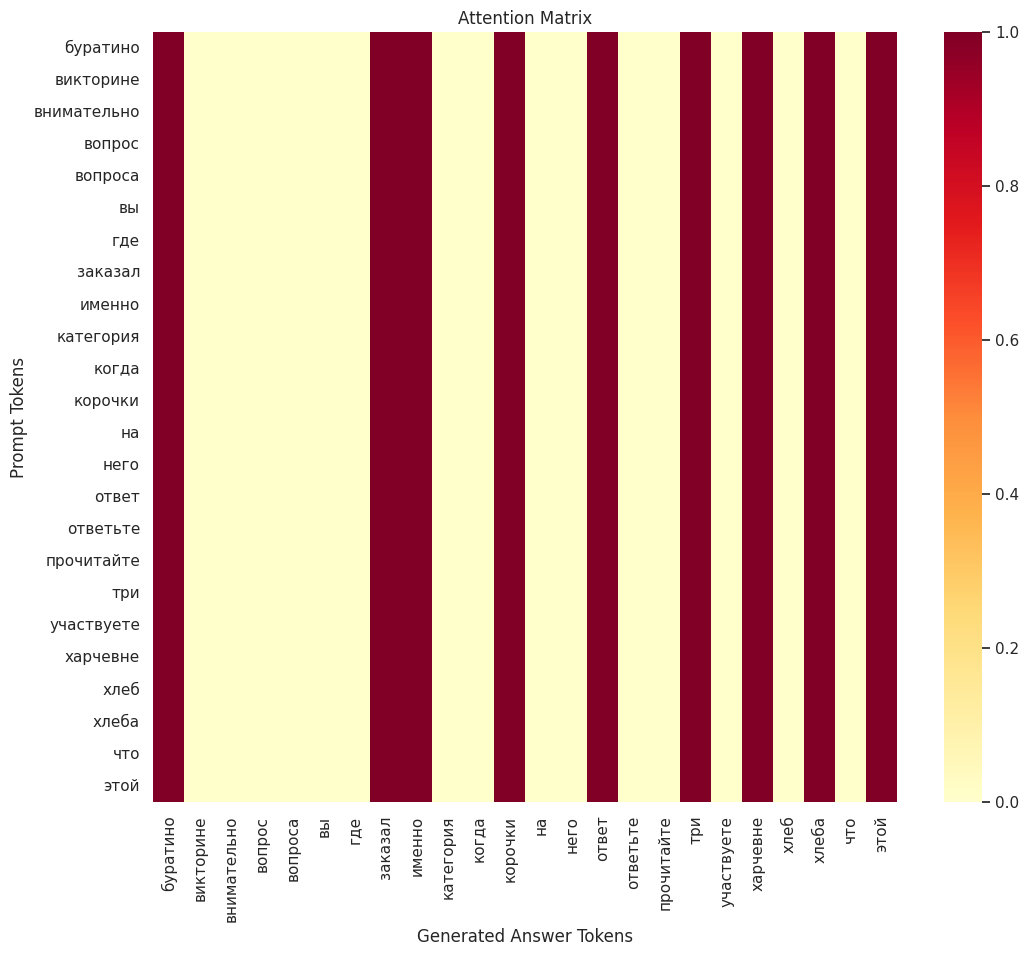

In [37]:
# tinyllama
prompt = df['prompt'][3] 
generated_answer = df['generated_answer'][3]

attention_matrix, tokens = create_attention_matrix(prompt, generated_answer)
visualize_attention_matrix(attention_matrix, tokens)

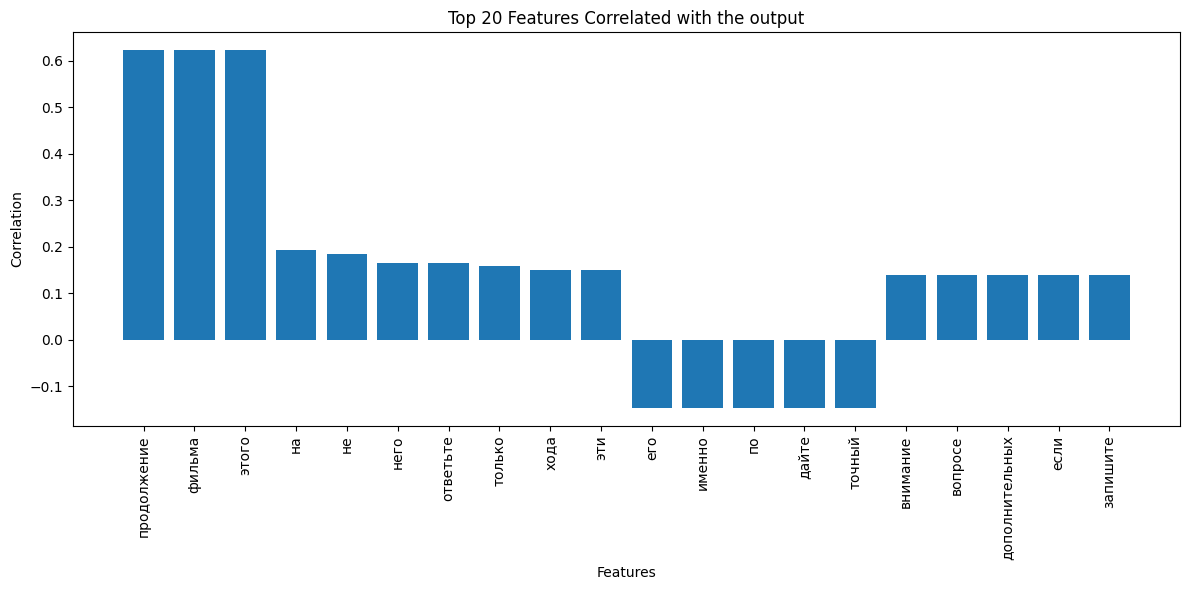

           feature  correlation
0      продолжение     0.622511
1           фильма     0.622511
2            этого     0.622511
3               на     0.192720
4               не     0.183866
5             него     0.164884
6         ответьте     0.164884
7           только     0.159617
8             хода     0.150775
9              эти     0.150775
10             его    -0.146112
11          именно    -0.146112
12              по    -0.146112
13           дайте    -0.146105
14          точный    -0.146105
15        внимание     0.138362
16         вопросе     0.138362
17  дополнительных     0.138362
18            если     0.138362
19        запишите     0.138362


In [28]:
# Shap Analogue
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import spearmanr

def analyze_input_impact_alternative(df, text_column='prompt', target_column='f1_score'):
    vectorizer = TfidfVectorizer(max_features=100) 
    X = vectorizer.fit_transform(df[text_column])
    
    feature_names = vectorizer.get_feature_names_out()
    correlations = []
    
    for i, feature in enumerate(feature_names):
        correlation, _ = spearmanr(X[:, i].toarray().flatten(), df[target_column])
        correlations.append((feature, correlation))
    
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    feature_importance = pd.DataFrame(correlations, columns=['feature', 'correlation'])
    
    plt.figure(figsize=(12, 6))
    plt.bar(feature_importance['feature'][:20], feature_importance['correlation'][:20])
    plt.title(f"Top 20 Features Correlated with the output")
    plt.xlabel("Features")
    plt.ylabel("Correlation")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Usage
feature_importance = analyze_input_impact_alternative(df)
print(feature_importance.head(20))


In [25]:
import shap
from transformers import pipeline

df = pd.read_csv("/kaggle/input/nir-generated-answers/tinyllama_chegeka_generated_results_with_f1.csv")
def perform_shap_analysis(model, tokenizer, df):
    explainer = shap.Explainer(pipeline('text-generation', model=model, tokenizer=tokenizer))
    shap_values = explainer(df['prompt'].tolist())
    
    shap.summary_plot(shap_values, df['prompt'])
    
    return shap_values

# shap_values = perform_shap_analysis(model, tokenizer, df)


KeyboardInterrupt



# Попарное сравнение

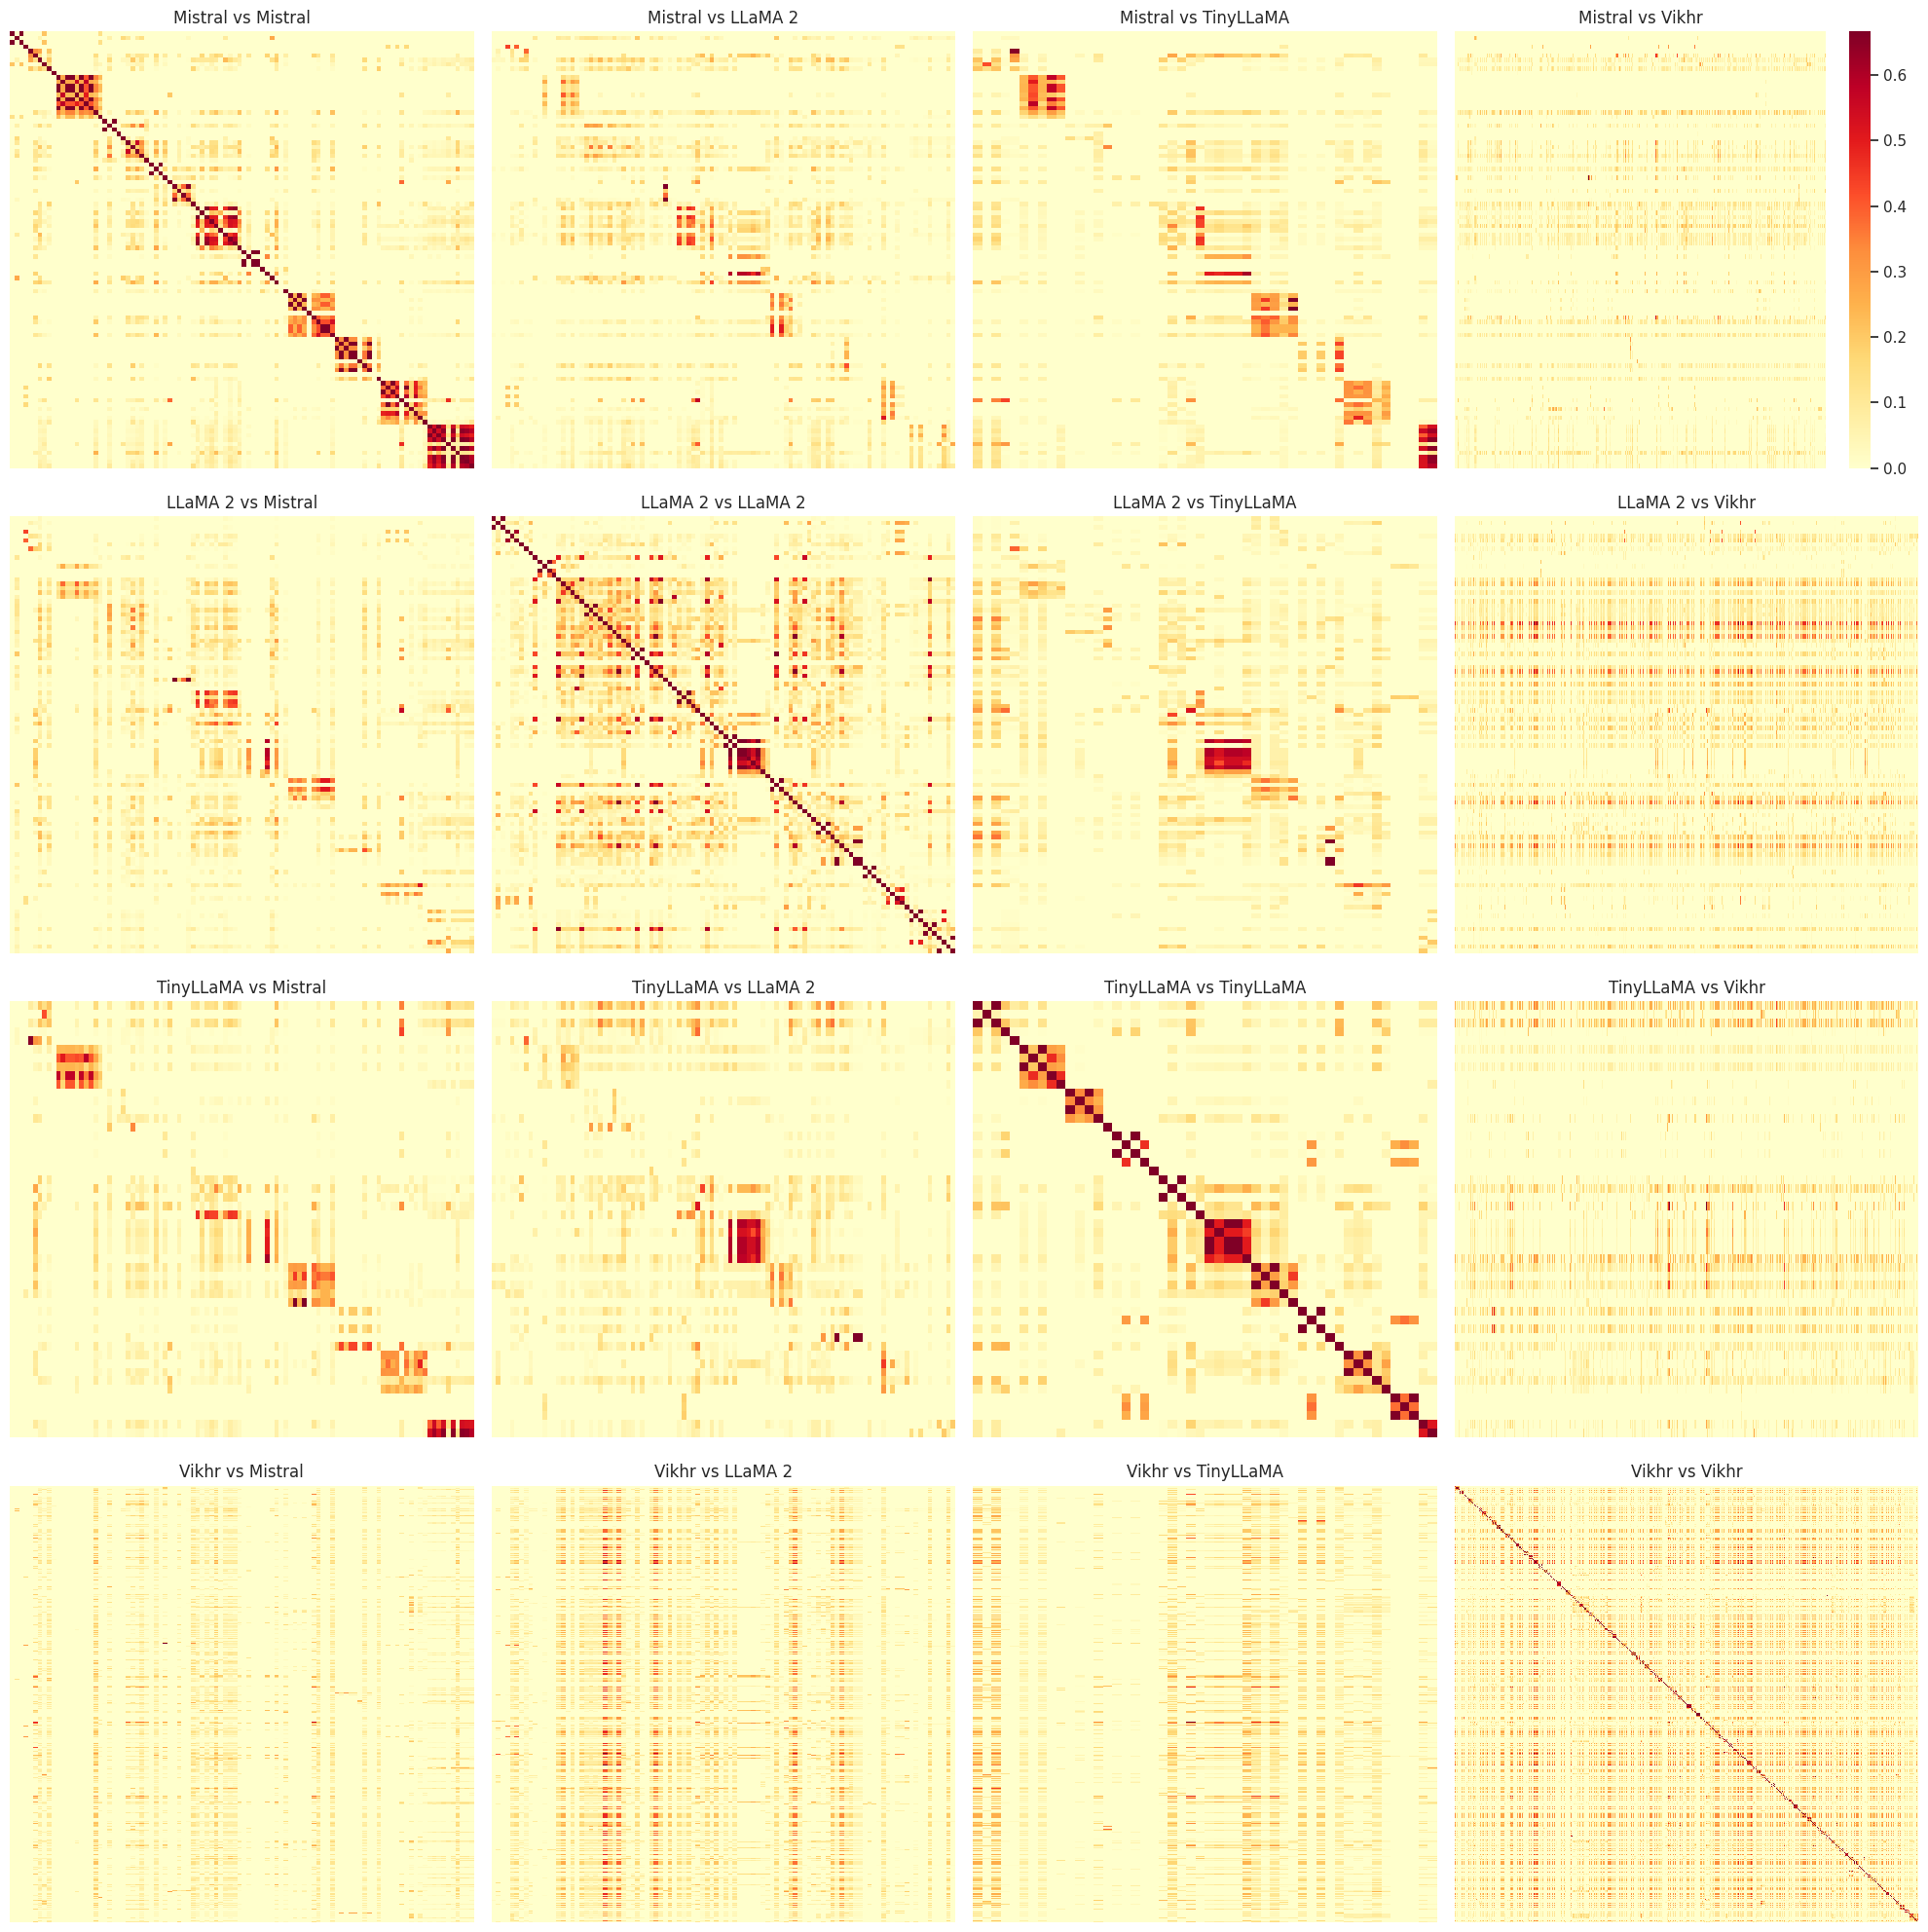

In [42]:
model_names = ['Mistral', 'LLaMA 2', 'TinyLLaMA', 'Vikhr']

def pairwise_comparison(df1, df2):
    all_answers = df1['generated_answer'].tolist() + df2['generated_answer'].tolist()
    vectorizer = CountVectorizer().fit(all_answers)
    vectors1 = vectorizer.transform(df1['generated_answer'])
    vectors2 = vectorizer.transform(df2['generated_answer'])
    similarities = cosine_similarity(vectors1, vectors2)
    return similarities

def visualize_pairwise_comparisons(dfs, model_names):
    n = len(dfs)
    fig, axes = plt.subplots(n, n, figsize=(20, 20))
    
    for i in range(n):
        for j in range(n):
            similarities = pairwise_comparison(dfs[i], dfs[j])
            
            ax = axes[i, j]
            sns.heatmap(similarities, ax=ax, cmap='YlOrRd', cbar=(i == 0 and j == n-1))
            ax.set_title(f'{model_names[i]} vs {model_names[j]}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('pairwise_comparisons.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize pairwise comparisons
visualize_pairwise_comparisons(dfs, model_names)

# Analyzing the Impact of Input Parts on Output

In [48]:
def analyze_input_influence(df):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['question'])
    feature_names = vectorizer.get_feature_names_out()
    
    correlations = []
    for i, feature in enumerate(feature_names):
        correlation = np.corrcoef(X[:, i].toarray().flatten(), df['f1_score'])[0, 1]
        correlations.append((feature, correlation))
    
    return sorted(correlations, key=lambda x: abs(x[1]), reverse=True)[:10]

for df, name in zip(dfs, model_names):
    print(f"\nTop influential input features for {name}:")
    for feature, correlation in analyze_input_influence(df):
        print(f"{feature}: {correlation:.4f}")


Top influential input features for Mistral:
евгения: 0.3704
матвеева: 0.3704
называется: 0.3704
продолжение: 0.3704
фильма: 0.3704
этого: 0.3704
его: -0.0974
что: -0.0974
именно: -0.0732
вистуют: 0.0721

Top influential input features for LLaMA 2:
вистуют: 0.4194
девятерной: 0.4194
категории: 0.4194
людей: 0.4194
только: 0.4194
эти: 0.4194
на: 0.2414
что: -0.1463
из: -0.1463
по: -0.1463

Top influential input features for TinyLLaMA:
евгения: 0.7061
матвеева: 0.7061
называется: 0.7061
продолжение: 0.7061
фильма: 0.7061
этого: 0.7061
его: -0.1445
именно: -0.1445
что: -0.1445
из: -0.1445

Top influential input features for Vikhr:
вистуют: 0.2488
девятерной: 0.2488
категории: 0.2488
людей: 0.2488
только: 0.2488
эти: 0.2488
берега: 0.2333
италии: 0.2333
морей: 0.2333
омывает: 0.2333


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


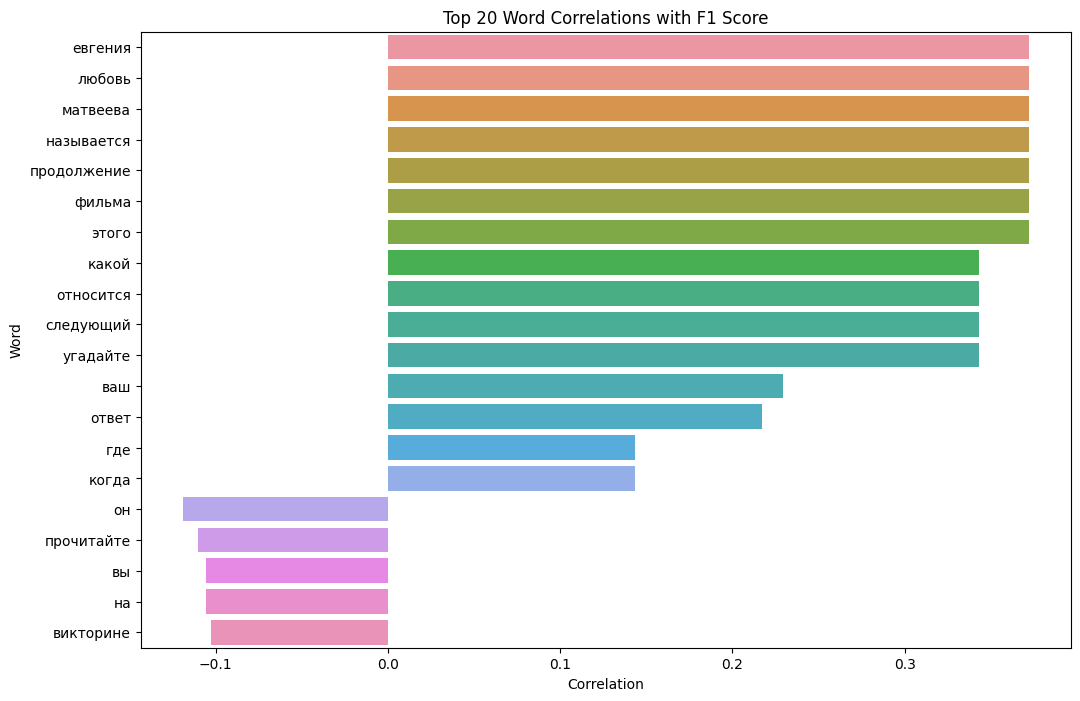

In [10]:
def analyze_input_influence(df):
    tfidf = TfidfVectorizer()
    question_tfidf = tfidf.fit_transform(df['prompt'])
    
    feature_names = tfidf.get_feature_names_out()
    
    # Calculate correlation between TF-IDF features and F1 score
    correlations = []
    for i in range(question_tfidf.shape[1]):
        correlation = np.corrcoef(question_tfidf[:, i].toarray().flatten(), df['f1_score'])[0, 1]
        correlations.append((feature_names[i], correlation))
    
    # Sort by absolute correlation value
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Plot top 20 correlations
    top_20 = correlations[:20]
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[x[1] for x in top_20], y=[x[0] for x in top_20], orient='h')
    plt.title('Top 20 Word Correlations with F1 Score')
    plt.xlabel('Correlation')
    plt.ylabel('Word')
    plt.show()

# Analyze input influence for the first dataset
analyze_input_influence(dataframes[0])

# 